In [190]:
#=====================================================
# Nome:   Diego Andrés Méndez
# N. USP: 7991531
#=====================================================

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import datetime

from mac0460_5832.utils import *

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 22/10/2018

(Ainda sem monitoria definida)

In [3]:
#adiciona border_size camadas de borda à imagem src
#Usa a função border para inputar os valores da borda
def add_border(src,border_size,border):
    border_src=np.zeros([src.shape[0]+2*border_size,src.shape[1]+2*border_size]).astype(bool)
    for i in range(len(border_src)):
        for j in range(len(border_src[i])):
            if i in range(border_size,src.shape[0]+border_size) and j in range(border_size,src.shape[1]+border_size):
                border_src[i,j]=src[i-border_size,j-border_size]
            else:
                border_src[i][j]=border(i-border_size,j-border_size)
    return border_src

In [4]:
# list_src_dest é uma lista de duplas para treinamento do operador W.
# O primeiro elemento de cada dupla é a imagem original e o segundo é a imagem desejada depois de aplicar o operador W.

# multi_window é uma lista multiresolução de janelas, da maior para a menor
# caso multi_window só possua uma janela, o caso se reduz ao de um w-operador comum

#border é uma função que retorna valores booleanos para os pontos fora da imagem src.

# Se track training for igual a True, todos os w_operadores intermediarios gerados a cada pixel treinado
# vão sendo adicionados à variável global track

def train_w_operator(list_src_dest,multi_window,border,multi_w_operator=None,track_training=False,limit=None):
    if track_training==True:
        global track
    if len(list_src_dest)==0:
        raise Exception('As lista list_src_dest tem comprimento 0!')
    
    if multi_w_operator==None:
        multi_w_operator=[]
        for i in range(len(multi_window)):
            multi_w_operator.append({})

    pad=abs(np.array(multi_window[0])).max()
    cont=0
    
    pontos=0
    
    # para cada dupla de imagens
    for src,dest in list_src_dest:
        src_pad=add_border(src,pad,border)
        print('Imagem '+str(cont+1)+' de '+str(len(list_src_dest))+'.')

        #para cada linha da imagem original
        for i in range(len(src)):
#             if (i+1)%100==0:
#                 print('Linha '+str(i+1)+' de '+str(len(src))+'.')

            #para cada ponto da linha da imagem original
            for j in range(len(src[i])):

                for k in range(len(multi_window)):
                    window=list(set(multi_window[k]))
                    window=sorted(window)
                    window=np.array(window)
                    window_transladada=window+np.array([i+pad,j+pad])
                    index_true=src_pad[tuple(window_transladada.transpose())].nonzero()
                    pontos_true=window[index_true]
                    pontos_tuple=tuple(map(tuple,pontos_true))

                    if dest[i,j]==True:
                        multi_w_operator[k][pontos_tuple]=multi_w_operator[k].get(pontos_tuple,0)+1
                    else:
                        multi_w_operator[k][pontos_tuple]=multi_w_operator[k].get(pontos_tuple,0)-1
                    if track_training==True:
                        track.append([dict(w_operator) for w_operator in multi_w_operator])
                pontos+=1
                if limit!=None and pontos>=limit:
                    return multi_w_operator
        cont+=1
        
    #retorna uma lista de dicionários, onde cada dicionário é um w-operador relativo a uma resolução de multi_window
    return multi_w_operator

In [5]:
# src é a imagem onde desejamos aplicar o operador W

# w_operator é o operador W já treinado

# multi_window é uma lista multiresolução de janelas, da maior para a menor
# caso multi_window só possua uma janela, o caso se reduz ao de um w-operador comum

# border é uma função que retorna valores booleanos para os pontos fora da imagem src.

# default é o valor atribuido a um pixel caso a sua janela não tenha sido vista no treinamento
# caso seja igual a 'src', o valor do próprio pixel é mantido
# caso seja igual a '-src', o valor do próprio pixel é invertido

# threshold é o limiar de ocorrencias do número de True menos o número de False encontrados para aquela janela
# para definir se o operador deve usar aquela janela ou uma de resolução menor

def apply_w_operator(src,multi_w_operator,multi_window,border,default=False,threshold=[]):
    
    if threshold==[]:
        threshold=[0]*len(multi_window)
    
    #cria a imagem de destino
    dest=np.zeros(src.shape,np.bool)
    
    pad=abs(np.array(multi_window[0])).max()
    
#     src_pad=np.pad(src,pad,'constant')
    src_pad=add_border(src,pad,border)
    
    #para cada linha da imagem original
    for i in range(len(src)):
#         if (i+1)%100==0:
#             print('Linha '+str(i+1)+' de '+str(len(src))+'.')
        
        #para cada ponto da linha da imagem original
        for j in range(len(src[i])):
            for k in range(len(multi_window)):
                window=list(set(multi_window[k]))
                window=sorted(window)
                window=np.array(window)
                window_transladada=window+np.array([i+pad,j+pad])
                index_true=src_pad[tuple(window_transladada.transpose())].nonzero()
                pontos_true=window[index_true]
                pontos_tuple=tuple(map(tuple,pontos_true))

                if multi_w_operator[k].get(pontos_tuple,0)>threshold[k]:
                    dest[i,j]=True
                    break
                elif multi_w_operator[k].get(pontos_tuple,0)<-threshold[k]:
                    dest[i,j]=False
                    break
                elif default=='src':
                    dest[i,j]=src_pad[i+pad,j+pad]
                elif default=='-src':
                    dest[i,j]= not src_pad[i+pad,j+pad]
                else:
                    dest[i,j]=default
                
    return dest

Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.


Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

In [154]:
dest=[read_img('imgs/q1/q1_dest.png')]*8

src=[]
for i in range(1,11):
    src.append(read_img('imgs/q1/q1_src'+str(i)+'.png'))

random.seed(0)
random.shuffle(src)
#utilizei uma permutação randômica da lista de imagens de treino.

def border(i,j):
    return False

In [6]:
print(datetime.datetime.now())

window1=[[(i,j) for i in range(-2,3) for j in range(-2,3)],
         [(i,j) for i in range(-2,3) if i%2==0 for j in range(-2,3) if j%2==0],
         [(0,0)]]

e_in1=[0]*8
e_eval1=[0]*8

n=0

#Validação cruzada, treinando com 8 imagens e validando com 2, cinco vezes, variando as imagens de treino e validação
#Fiz isso para cada janela multiresolução.
#Ou seja, cross-validation com n=10 e k=2
for i in range(0,10,2):
    n+=1
    print('\n\nValidação '+str(n)+'\n\n')
    w_operator1=[]
    for i in range(len(window1)):
        w_operator1.append({})
    x_train=src[:i]+src[i+2:]
    x_eval=src[i:i+2]
    
    #a cada imagem a mais usada no treino, calculei e_in e e_val 
    for j in range(8):
        print('\nTraining\n')
        w_operator1=train_w_operator(list(zip(x_train[:j+1],dest[:j+1])),window1,border,multi_w_operator=w_operator1)
        print('\nE_in\n')
        erro=0
        for k in range(j+1):
            foo=apply_w_operator(x_train[k],w_operator1,window1,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/(j+1)
        e_in1[j]+=erro
        print('\nE_eval\n')
        erro=0
        for k in range(2):
            foo=apply_w_operator(x_eval[k],w_operator1,window1,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/2
        e_eval1[j]+=erro
    
e_in1=[e_in1[i]/5 for i in range(len(e_in1))]
e_eval1=[e_eval1[i]/5 for i in range(len(e_eval1))]

print(datetime.datetime.now())

2018-10-28 01:53:09.545940


Validação 1



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Imagem 1 de 4.
Imagem 2 de 4.
Imagem 3 de 4.
Imagem 4 de 4.

E_in


E_eval


Training

Imagem 1 de 5.
Imagem 2 de 5.
Imagem 3 de 5.
Imagem 4 de 5.
Imagem 5 de 5.

E_in


E_eval


Training

Imagem 1 de 6.
Imagem 2 de 6.
Imagem 3 de 6.
Imagem 4 de 6.
Imagem 5 de 6.
Imagem 6 de 6.

E_in


E_eval


Training

Imagem 1 de 7.
Imagem 2 de 7.
Imagem 3 de 7.
Imagem 4 de 7.
Imagem 5 de 7.
Imagem 6 de 7.
Imagem 7 de 7.

E_in


E_eval


Training

Imagem 1 de 8.
Imagem 2 de 8.
Imagem 3 de 8.
Imagem 4 de 8.
Imagem 5 de 8.
Imagem 6 de 8.
Imagem 7 de 8.
Imagem 8 de 8.

E_in


E_eval



Validação 2



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Ima

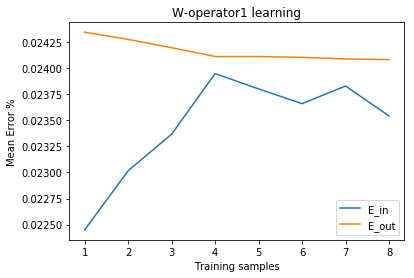

In [7]:
plt.plot(range(1,len(e_in1)+1),e_in1)
plt.plot(range(1,len(e_eval1)+1),e_eval1)
plt.ylabel('Mean Error %')
plt.xlabel('Training samples')
plt.title('W-operator1 learning')
plt.legend(['E_in', 'E_out'], loc='lower right')
plt.show()

In [8]:
print(datetime.datetime.now())

window2=[[(i,j) for i in range(-2,3) for j in range(-2,3)],
         [(i,j) for i in range(-1,2) for j in range(-1,2)],
         [(0,0)]]



e_in2=[0]*8
e_eval2=[0]*8

n=0
for i in range(0,10,2):
    n+=1
    print('\n\nValidação '+str(n)+'\n\n')
    w_operator2=[]
    for i in range(len(window2)):
        w_operator2.append({})
    x_train=src[:i]+src[i+2:]
    x_eval=src[i:i+2]
    for j in range(8):
        print('\nTraining\n')
        w_operator2=train_w_operator(list(zip(x_train[:j+1],dest[:j+1])),window2,border,multi_w_operator=w_operator2)
        print('\nE_in\n')
        erro=0
        for k in range(j+1):
            foo=apply_w_operator(x_train[k],w_operator2,window2,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/(j+1)
        e_in2[j]+=erro
        print('\nE_eval\n')
        erro=0
        for k in range(2):
            foo=apply_w_operator(x_eval[k],w_operator2,window2,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/2
        e_eval2[j]+=erro
    
e_in2=[e_in2[i]/5 for i in range(len(e_in2))]
e_eval2=[e_eval2[i]/5 for i in range(len(e_eval2))]

print(datetime.datetime.now())

2018-10-28 03:55:09.938370


Validação 1



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Imagem 1 de 4.
Imagem 2 de 4.
Imagem 3 de 4.
Imagem 4 de 4.

E_in


E_eval


Training

Imagem 1 de 5.
Imagem 2 de 5.
Imagem 3 de 5.
Imagem 4 de 5.
Imagem 5 de 5.

E_in


E_eval


Training

Imagem 1 de 6.
Imagem 2 de 6.
Imagem 3 de 6.
Imagem 4 de 6.
Imagem 5 de 6.
Imagem 6 de 6.

E_in


E_eval


Training

Imagem 1 de 7.
Imagem 2 de 7.
Imagem 3 de 7.
Imagem 4 de 7.
Imagem 5 de 7.
Imagem 6 de 7.
Imagem 7 de 7.

E_in


E_eval


Training

Imagem 1 de 8.
Imagem 2 de 8.
Imagem 3 de 8.
Imagem 4 de 8.
Imagem 5 de 8.
Imagem 6 de 8.
Imagem 7 de 8.
Imagem 8 de 8.

E_in


E_eval



Validação 2



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Ima

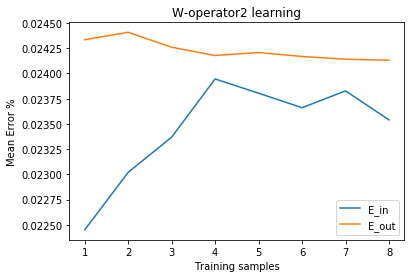

In [9]:
plt.plot(range(1,len(e_in2)+1),e_in2)
plt.plot(range(1,len(e_eval2)+1),e_eval2)
plt.ylabel('Mean Error %')
plt.xlabel('Training samples')
plt.title('W-operator2 learning')
plt.legend(['E_in', 'E_out'], loc='lower right')
plt.show()

In [10]:
print(datetime.datetime.now())

window3=[[(i,j) for i in range(-2,3) for j in range(-2,3)],
         [(i,j) for i in range(-2,3) for j in range(-2,3) if abs(i)+abs(j)<=2],
         [(i,j) for i in range(-2,3) for j in range(-2,3) if abs(i)+abs(j)<=1],
         [(0,0)]]



e_in3=[0]*8
e_eval3=[0]*8

n=0
for i in range(0,10,2):
    n+=1
    print('\n\nValidação '+str(n)+'\n\n')
    w_operator3=[]
    for i in range(len(window3)):
        w_operator3.append({})
    x_train=src[:i]+src[i+2:]
    x_eval=src[i:i+2]
    for j in range(8):
        print('\nTraining\n')
        w_operator3=train_w_operator(list(zip(x_train[:j+1],dest[:j+1])),window3,border,multi_w_operator=w_operator3)
        print('\nE_in\n')
        erro=0
        for k in range(j+1):
            foo=apply_w_operator(x_train[k],w_operator3,window3,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/(j+1)
        e_in3[j]+=erro
        print('\nE_eval\n')
        erro=0
        for k in range(2):
            foo=apply_w_operator(x_eval[k],w_operator3,window3,border)
            erro+=(foo!=dest[0]).sum()/foo.size
        erro=erro/2
        e_eval3[j]+=erro
    
e_in3=[e_in3[i]/5 for i in range(len(e_in3))]
e_eval3=[e_eval3[i]/5 for i in range(len(e_eval3))]

print(datetime.datetime.now())

2018-10-28 05:56:58.841677


Validação 1



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Imagem 1 de 4.
Imagem 2 de 4.
Imagem 3 de 4.
Imagem 4 de 4.

E_in


E_eval


Training

Imagem 1 de 5.
Imagem 2 de 5.
Imagem 3 de 5.
Imagem 4 de 5.
Imagem 5 de 5.

E_in


E_eval


Training

Imagem 1 de 6.
Imagem 2 de 6.
Imagem 3 de 6.
Imagem 4 de 6.
Imagem 5 de 6.
Imagem 6 de 6.

E_in


E_eval


Training

Imagem 1 de 7.
Imagem 2 de 7.
Imagem 3 de 7.
Imagem 4 de 7.
Imagem 5 de 7.
Imagem 6 de 7.
Imagem 7 de 7.

E_in


E_eval


Training

Imagem 1 de 8.
Imagem 2 de 8.
Imagem 3 de 8.
Imagem 4 de 8.
Imagem 5 de 8.
Imagem 6 de 8.
Imagem 7 de 8.
Imagem 8 de 8.

E_in


E_eval



Validação 2



Training

Imagem 1 de 1.

E_in


E_eval


Training

Imagem 1 de 2.
Imagem 2 de 2.

E_in


E_eval


Training

Imagem 1 de 3.
Imagem 2 de 3.
Imagem 3 de 3.

E_in


E_eval


Training

Ima

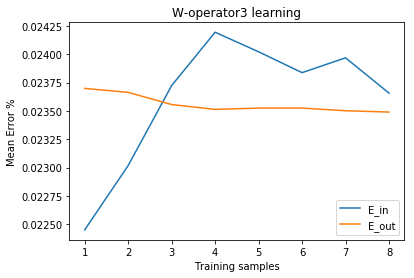

In [11]:
plt.plot(range(1,len(e_in3)+1),e_in3)
plt.plot(range(1,len(e_eval3)+1),e_eval3)
plt.ylabel('Mean Error %')
plt.xlabel('Training samples')
plt.title('W-operator3 learning')
plt.legend(['E_in', 'E_out'], loc='lower right')
plt.show()

In [157]:
#A janela multiresolução 3 obteve o melhor e_val, e por isso será usava para treinar nas 10 imagens.

print(datetime.datetime.now())

window3=[[(i,j) for i in range(-2,3) for j in range(-2,3)],
         [(i,j) for i in range(-2,3) for j in range(-2,3) if abs(i)+abs(j)<=2],
         [(i,j) for i in range(-2,3) for j in range(-2,3) if abs(i)+abs(j)<=1],
         [(0,0)]]

w_operator=train_w_operator(list(zip(src,[dest[0]]*10)),window3,border)

2018-10-28 20:43:39.574364
Imagem 1 de 10.
Imagem 2 de 10.
Imagem 3 de 10.
Imagem 4 de 10.
Imagem 5 de 10.
Imagem 6 de 10.
Imagem 7 de 10.
Imagem 8 de 10.
Imagem 9 de 10.
Imagem 10 de 10.


In [158]:
new_images=[]
for img in src:
    new_images.append(apply_w_operator(img,w_operator,window3,border))

In [166]:
#este é o e_in final obtido usando a janela 3
e_in=0
for i in range(10):
    e_in+=(new_images[i]!=dest[0]).sum()/dest[0].size
e_in=e_in/10
print(e_in)

0.023566015625


Q2. Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

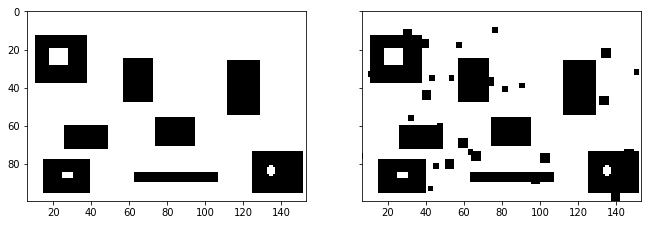

In [172]:
# Exemplo 
draw_img_pair(read_img('imgs/q2/dest.png'), read_img('imgs/q2/src0.png'), figsz=(11, 3.5))

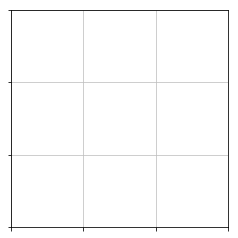

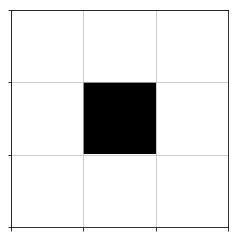

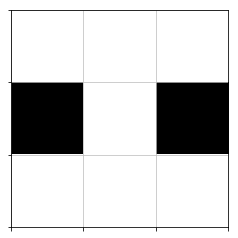

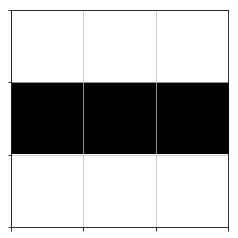

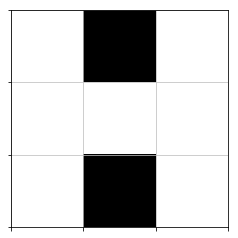

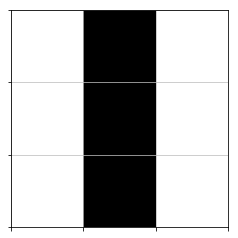

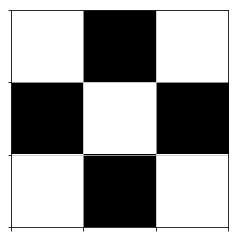

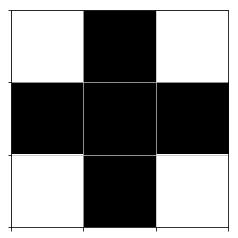

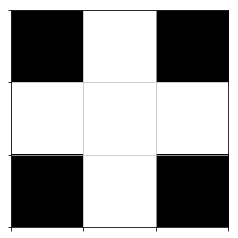

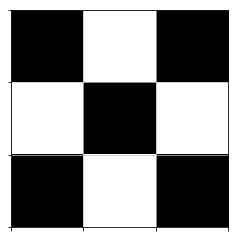

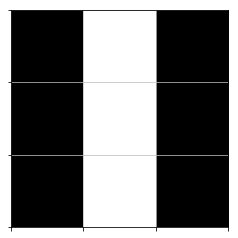

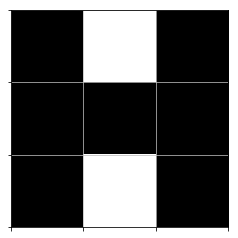

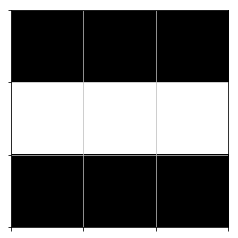

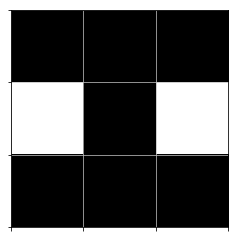

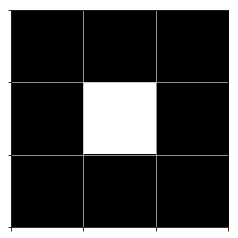

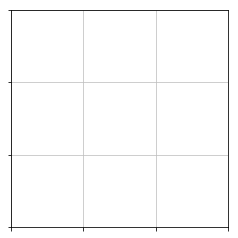

In [184]:
#seleciona as janelas 3x3 que possuem simetria vertical e horizontal

elements=[]
for i in range(2**9):
    el=np.array([bool(int(b)) for b in bin(i)[2:].zfill(9)]).reshape(3,3)
    if np.array_equal(np.flip(el,axis=0),el) and np.array_equal(np.flip(el,axis=1),el):
        elements.append(el)
        draw_img(el)

In [174]:
#aplica uma erosao e uma dilatação (abertura) seguida de uma dilatação e uma erosão (fechamento),
#variando as janelas utilizadas entre as definidas acima.

#Caso o melhor seja utilizar somente uma abertura ou somente um fechamento, o proprio aprendizado decidirá que
#as janelas a serem utilizadas pelo operador que não será utilizado possuem somente o ponto central. 


e_in={}
images=[]
for n in range(5):
    images.append(read_img('imgs/q2/src'+str(n)+'.png'))
dest=read_img('imgs/q2/dest.png')
for n in range(5):
    print(n)
    img=images[n]
    for i,e1 in enumerate(elements):
        img_e1=erosion(img,b=e1)
        for j,d1 in enumerate(elements):
            img_d1=dilation(img_e1,b=d1)
            for k,d2 in enumerate(elements):
                img_d2=dilation(img_d1,b=d2)
                for l,e2 in enumerate(elements):
                    img_e2=erosion(img_d2,b=e2)
                    e_in[(i,j,k,l)]=e_in.get((i,j,k,l),0)+(img_e2!=dest).sum()
                    
for key in e_in:
    e_in[key]=(e_in[key]/5)/dest.size

0
1
2
3
4


In [175]:
#seleciona a combinação de janelas com menor e_in
key=min(e_in,key=lambda x:e_in[x])

In [176]:
#e_in obtido pela melhor combinação de janelas
e_in[key]

0.015287499999999999

In [177]:
#melhor sequência de janelas
key

(8, 6, 6, 14)

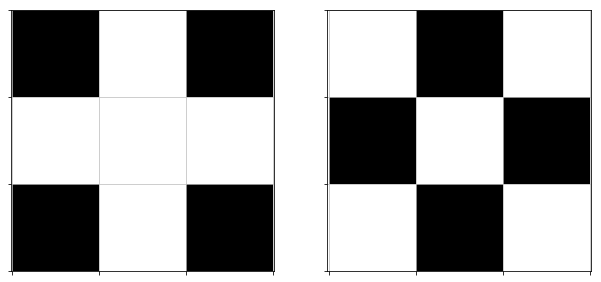

In [178]:
draw_img_pair(elements[key[0]],elements[key[1]])

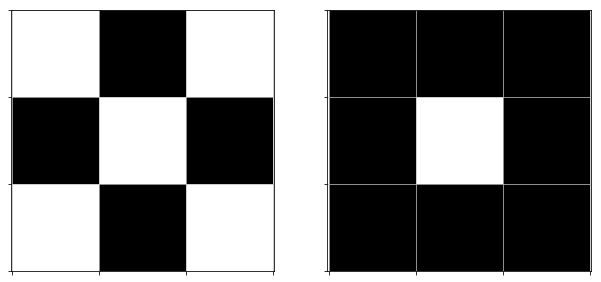

In [179]:
draw_img_pair(elements[key[2]],elements[key[3]])

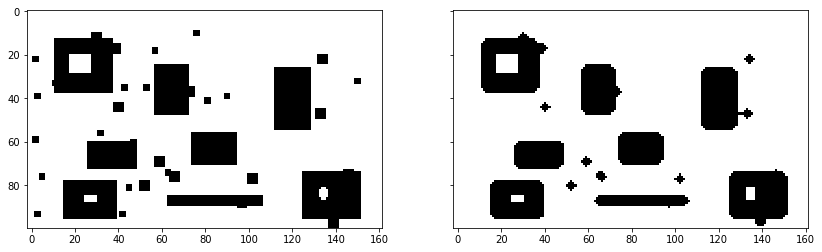

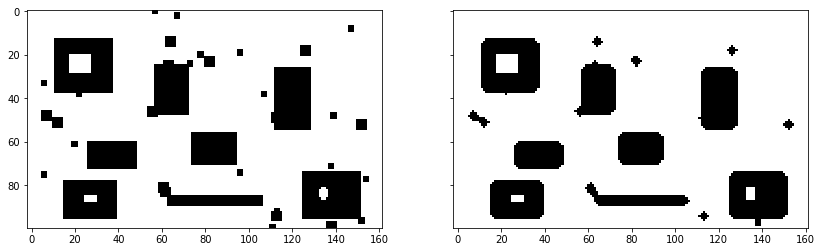

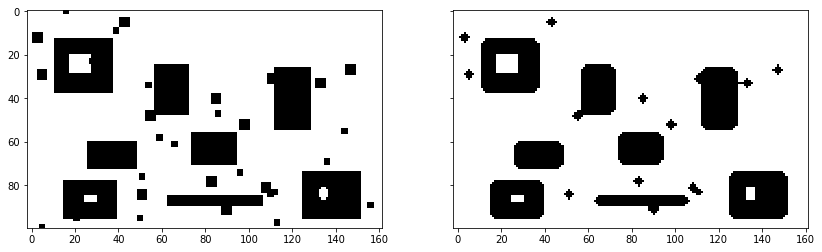

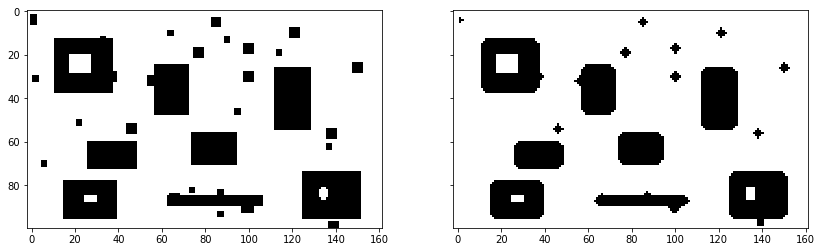

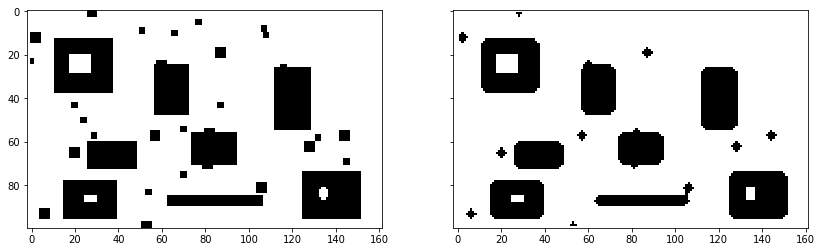

In [180]:
#comparação das imagens de treino antes e depois de aplicar o operador selecionado
for i in range(5):
    new_image=erosion(dilation(dilation(erosion(images[i],b=elements[key[0]]),b=elements[key[1]]),b=elements[key[2]]),b=elements[key[3]])
    draw_img_pair(images[i],new_image,figsz=(14,4))

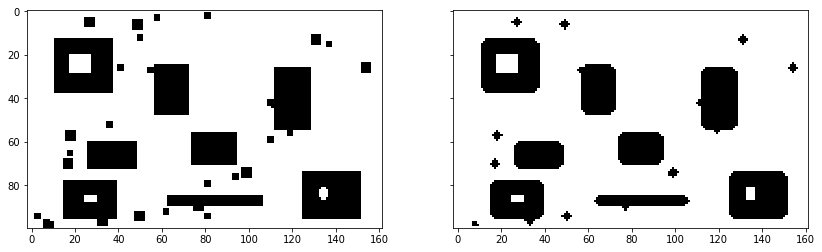

E_out = 0.014625


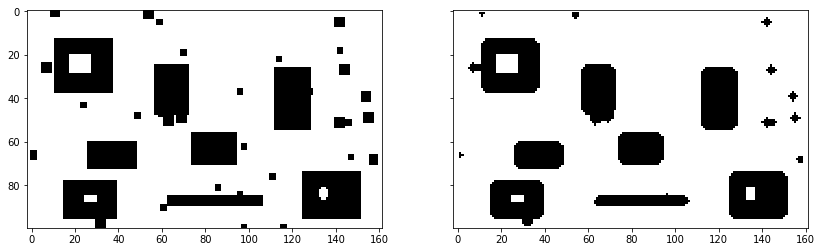

E_out = 0.01625


In [181]:
#comparação das imagens de teste antes e depois de aplicar o operador selecionado
tests=[read_img('imgs/q2/test0.png'),read_img('imgs/q2/test1.png')]
e_out=[0,0]

for i in range(2):
    new_image=erosion(dilation(dilation(erosion(tests[i],b=elements[key[0]]),b=elements[key[1]]),b=elements[key[2]]),b=elements[key[3]])
    e_out[i]=(new_image!=dest).sum()/dest.size
    draw_img_pair(tests[i],new_image,figsz=(14,4))
    print('E_out = '+str(e_out[i]))

In [183]:
#e_out final
sum(e_out)/len(e_out)

0.0154375